Handwritten Digit Recognition Using Neural Networks and the MNIST Dataset

In [1]:
# %pip install ipywidgets
# %pip install matplotlib
# %pip install tensorflow

In [2]:
try:
    import cupy as np # Cupy is a GPU-accelerated (NVidia CUDA) drop-in replacement for NumPy
    is_cupy = True
    print("Using CuPy for GPU acceleration.")
except ImportError:
    import numpy as np
    is_cupy = False
    print("No GPU acceleration. Using NumPy for CPU computation.")

import time
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as npb # Tensflor will error on np.argmax when cupy, so npb.argmax
from IPython.display import display, clear_output
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

Using CuPy for GPU acceleration.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Ensure the path exists
NN_FILE_PATH = '/content/drive/MyDrive/NN3090/'

if not os.path.exists(NN_FILE_PATH):
   os.makedirs(NN_FILE_PATH)
   print("Created Directory", NN_FILE_PATH)
else:
  print("Directory exists " + NN_FILE_PATH)

Directory exists /content/drive/MyDrive/NN3090/


In [5]:
# Helper functions
def load_mnist(unwrap=False):
    """Load and preprocess MNIST data"""
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Reshape image to column vector,
    X_train = np.array(X_train.reshape(X_train.shape[0], -1)) / 255.0
    Y_train = np.array(to_categorical(Y_train, 10))

    X_test = np.array(X_test.reshape(X_test.shape[0], -1)) / 255.0
    Y_test = np.array(to_categorical(Y_test, 10))

    if unwrap is True:
        # Transform cupy to numpy for tensorflow
        if is_cupy:
            X_train, Y_train, X_test, Y_test  = np.asnumpy(X_train), np.asnumpy(Y_train), np.asnumpy(X_test), np.asnumpy(Y_test)
        return X_train, Y_train, X_test, Y_test

    return X_train.T, Y_train.T, X_test.T, Y_test.T

# Plotting
def show_prediction(X, id, predicted, actual):
    plt.figure()
    plt.imshow(X.reshape(28, 28), cmap='gray')
    plt.title(f"Image {id}: Predicted {predicted}, Actual {actual}")
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()

def show_empty():
    x = np.zeros(shape=(28,28))
    if is_cupy:
        x = np.asnumpy(x)

    plt.figure()
    plt.imshow(x, cmap='gray')
    plt.title(" ")
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()

### **ReLU Activation**:

$$\text{ReLU}(x_i) = \max(0, x_i)$$

$$
\frac{\partial}{\partial x_i}[\text{ReLU}(x_i)] =
\begin{cases}
1 & \text{if } x_i > 0, \\
0 & \text{if } x_i \leq 0.
\end{cases}
$$

### **Softmax Activation**:

$$\hat{y}_i = \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

$$
\frac{\partial \hat{y}_i}{\partial z_k} =
\begin{cases}
\hat{y}_i (1 - \hat{y}_i) & \text{if } i = k, \\
-\hat{y}_i \hat{y}_k & \text{if } i \neq k.
\end{cases}
$$

used for classification

### **Cross-Entropy Loss**:

$$L(\hat{y}_i) = -\sum_{i} y_i \log(\hat{y}_i)$$
$$
\frac{\partial L}{\partial \hat{y}_i} = -\frac{y_i}{\hat{y}_i}.
$$
where $y_i$ is the true label, and $\hat{y}_i$ is the predicted probability from softmax.

\

Optimization for $\frac{\partial}{\partial z_k}(\text{softmax} \circ \text{crossentropy}) $

$$
\frac{\partial L}{\partial \hat{y}_i}\frac{\partial \hat{y}_i}{\partial z_k}
= \frac{\partial L}{\partial z_k}
= \hat{y}_i - y_i
$$

In [6]:
# Activation Functions
def relu(weighted_input):
    """Applies the ReLU activation function."""
    return np.maximum(0, weighted_input)

def relu_derivative(weighted_input):
    """Computes the derivative of the ReLU function."""
    return np.where(weighted_input > 0, 1, 0)

def softmax(weighted_input):
    """Applies the softmax activation function for classification."""
    # we use z_i = weighted_i - max(weighted) for stability, to avoid overflow,
    # but mathemtically equivalent
    exp_weighted_input = np.exp(weighted_input - np.max(weighted_input, axis=0, keepdims=True))
    return exp_weighted_input / np.sum(exp_weighted_input, axis=0, keepdims=True)

def cross_entropy_loss(Y_pred, Y_true):
    """Calculates the cross-entropy loss between predicted and true labels."""
    m = Y_true.shape[1]
    # divide by m for average loss per prediction
    return -np.sum(Y_true * np.log(Y_pred + 1e-9)) / m

def cross_entropy_softmax_derivative(Y_pred, Y_true):
    """Computes the derivative of the cross-entropy loss with softmax function."""
    return Y_pred - Y_true


### Custom Neural Network implementation

In [7]:
# Layer Class holds the weights and biases managing forward/backward propagation for itself
class Layer:
    def __init__(self, input_size, output_size, activation_fn, activation_derivative_fn=None):
        """Initializes a layer of the neural network."""

        self.weight = np.random.randn(output_size, input_size) * 0.01
        self.bias = np.zeros((output_size, 1))
        self.activation_fn = activation_fn
        self.activation_derivative_fn = activation_derivative_fn if activation_derivative_fn else lambda weighted_input: 1

    def forward(self, activation_output_prev):
        """Performs the forward pass for this layer."""

        self.activation_output_prev = activation_output_prev
        self.weighted_input = np.dot(self.weight, activation_output_prev) + self.bias
        self.activation_output = self.activation_fn(self.weighted_input)
        return self.activation_output

    def backward(self, dA, learning_rate):
        """Performs the backward pass for this layer and updates the parameters."""

        m = self.activation_output_prev.shape[1]
        dZ = dA * self.activation_derivative_fn(self.weighted_input)
        dW = np.dot(dZ, self.activation_output_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m

        # Update weights and biases (Gradient Descent)
        # x_{n+1} = x_n - alpha * gradient(x)
        self.weight -= learning_rate * dW
        self.bias -= learning_rate * db

        dA_prev = np.dot(self.weight.T, dZ)
        return dA_prev

    @staticmethod
    def create_layers(arr):
        """Creates a list of Layer objects based on the specified layer sizes."""

        layer_objects = []
        for i in range(len(arr) - 1):
            input_size = arr[i]
            output_size = arr[i + 1]
            if i == len(arr) - 2:
                layer_objects.append(Layer(input_size, output_size, softmax))
            else:
                layer_objects.append(Layer(input_size, output_size, relu, relu_derivative))

        return layer_objects

# Neural Network Class, manages layers and helpers to train, predict and evaluate
class NeuralNetwork:
    def __init__(self, layers, loss_fn=cross_entropy_loss, loss_derivative=cross_entropy_softmax_derivative, learning_rate=0.01, min_delta=0.001):
        """Initializes the neural network with the given layers."""

        self.layers = Layer.create_layers(layers)
        self.loss_fn = loss_fn
        self.loss_derivative = loss_derivative
        self.learning_rate = learning_rate

    def forward_propagation(self, X):
        """Performs forward propagation through the entire network."""

        activation_output = X
        for layer in self.layers:
            activation_output = layer.forward(activation_output)

        return activation_output

    def backward_propagation(self, X, Y):
        """Performs backward propagation through the entire network to compute gradients."""
        Y_pred = self.forward_propagation(X)

        # Gradient Descent Implemented
        dA = self.loss_derivative(Y_pred, Y)

        for layer in reversed(self.layers):
            dA = layer.backward(dA, self.learning_rate)

    def train_step(self, X_batch, Y_batch):
        """Performs a single training step on a batch of data."""
        self.backward_propagation(X_batch, Y_batch)
        return self.loss_fn(self.forward_propagation(X_batch), Y_batch)

    def train(self, X, Y, batch_callback=None, epochs=1000, batch_size=32, min_loss=None):
        """Trains the neural network using the given data"""
        min_loss = max(0, min_loss or 0) # Clamp min_loss to 0

        for epoch in range(epochs):
            permutation = np.random.permutation(X.shape[1])
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]

            # Since we're doing by batches,
            # Technically Stochastic Gradient Descent Implemented
            for i in range(0, X.shape[1], batch_size):
                X_batch = X_shuffled[:, i:i + batch_size]
                Y_batch = Y_shuffled[:, i:i + batch_size]
                loss = self.train_step(X_batch, Y_batch)

            results = 0
            if batch_callback:
              l, a = self.evaluate(X_shuffled, Y_shuffled)
              results = batch_callback(self, batch_size, epoch, epochs, l, a) if batch_callback else 1

            if loss < max(0, min_loss or 0) or results is False:
                return

    def predict(self, X):
        """Evaluates the network's performance on the given data."""

        Y_pred = self.forward_propagation(X)
        # If X = [ [I_5], [I_9] ]
        # Y_pred = [[0, 0.1, 0, 0.2, 0, 0.7, 0, 0, 0, 0, 0],
                   #[0, 0.1, 0, 0.2, 0, 0.1, 0, 0, 0, 0, 0.6] ]
        predictions = np.argmax(Y_pred, axis=0) # [5,9]

        return predictions

    def evaluate(self, X, Y):
        """Calculates accuracy for Y given X"""

        Y_pred = self.forward_propagation(X)
        predictions = np.argmax(Y_pred, axis=0)

        labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == labels)
        loss = self.loss_fn(np.clip(Y_pred, 1e-12, 1. - 1e-12), Y)

        return (loss.item(), accuracy.item())

    def save(self, filepath):
        """Saves the layers to filepath in .npz format."""
        layers_data = {}
        for i, layer in enumerate(self.layers):
            layers_data[f'layer_{i}_weight'] = layer.weight
            layers_data[f'layer_{i}_bias'] = layer.bias
        layers_data['num_layers'] = len(self.layers)  # Save the number of layers
        np.savez(filepath, **layers_data)

    @staticmethod
    def load(filepath, loss_fn=None, learning_rate=0.01):
        """Loads only the layers' parameters from a .npz file."""
        if not os.path.exists(filepath):
            return None

        with np.load(filepath, allow_pickle=False) as model_data:  # Explicitly avoid pickling
            num_layers = int(model_data['num_layers'])  # Retrieve the number of layers
            layers = []

            for i in range(num_layers):
                weight = model_data[f'layer_{i}_weight']
                bias = model_data[f'layer_{i}_bias']

                # Recreate the layer with correct dimensions
                layer = Layer(weight.shape[1], weight.shape[0], relu)
                layer.weight = np.array(weight) if is_cupy else weight
                layer.bias = np.array(bias) if is_cupy else bias
                layers.append(layer)

        nn = NeuralNetwork([], loss_fn=loss_fn or cross_entropy_loss, learning_rate=learning_rate)
        nn.layers = layers
        return nn

### Forward Propagation

$$\hat{Y} = softmax(W_4 \cdot relu_3(W_3 \cdot relu_2(W_2 \cdot relu_1(W_1 \cdot X + b_1) + b_2) + b_3) + b_4) $$

\

### Gradient Descent
To minimize a loss function $L$

#### Weight Update Rule:

$
w_{ij} \gets w_{ij} - \alpha \cdot \frac{\partial L}{\partial w_{ij}}
$

#### Bias Update Rule:
$
b_j \gets b_j - \alpha \cdot \frac{\partial L}{\partial b_j}
$

Where:

-    $\alpha$: Learning rate, controlling the step size.
-    $\frac{\partial L}{\partial w_{ij}}$: Gradient of the loss with respect to weight $w_{ij}$.
-    $\frac{\partial L}{\partial b_j}$: Gradient of the loss with respect to bias $b_j$.

### Tensorflow Neural Network

In [8]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras import layers, models

class TensorflowNeuralNetwork:
    def __init__(self, network_layer, learning_rate=0.01, use_adam=False):
        """Initializes the CNN with a given structure."""
        self.model = models.Sequential()

        # Build NN from network_layer description
        if len(network_layer) > 0:
          last_layer = network_layer[-1]
          if not isinstance(last_layer, int):
              raise ValueError(f"Must be integer: {last_layer}")

          first_layer = network_layer[0]
          hidden_layer = network_layer[1:-1]

          if isinstance(first_layer, tuple):
              # If the first layer is a tuple, we add a sequential layer to start with
              a,b = first_layer
              first_layer = a*b
              hidden_layer = network_layer[0:-1]

          self.model.add(layers.Dense(first_layer, activation='relu'))
          prev_layer = first_layer

          # Build the hidden layer
          for cur_layer in hidden_layer:
              if isinstance(cur_layer, int):
                  if isinstance(prev_layer, tuple):
                      # Flatten convolution before sending to sequential layer
                      self.model.add(layers.Flatten())

                  # Add layer for sequential
                  self.model.add(layers.Dense(cur_layer, activation='relu'))
              elif isinstance(cur_layer, tuple):
                  x,y = cur_layer
                  # if last layer was a 1D layer,
                  # reshape required to transform into 2D convolution
                  if isinstance(prev_layer, int):
                      self.model.add(layers.Reshape((x, y, 1)))

                  # Add convolution, use smaller kernel size considering our data
                  self.model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))

                  if isinstance(prev_layer, tuple) and x > 2 and y > 2:  # Only pool if dimensions are sufficient
                      # Only pool if we have consecutive convolutions
                      # We do it on 2 convolutions since our network is so small
                      self.model.add(layers.MaxPooling2D(pool_size=(2, 2)))
              prev_layer = cur_layer

          if isinstance(prev_layer, tuple):
              self.model.add(layers.Flatten())

          # Add the last layer using softmax to classify
          self.model.add(layers.Dense(last_layer, activation='softmax'))

        # Compile the model with cross-entropy loss and an optimizer
        optimizer = tf.keras.optimizers.Adam if use_adam else tf.keras.optimizers.SGD
        self.model.compile(optimizer=optimizer(learning_rate=learning_rate),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    class BatchCallback(tf.keras.callbacks.Callback):
        def __init__(self, nn, batch_size, total_epochs, callback):
            super().__init__()
            self.nn = nn
            self.batch_size = batch_size
            self.total_epochs = total_epochs
            self.callback = callback

        def on_epoch_end(self, epoch, logs=None):
            if not self.callback:
                return

            # Extract the BATCH accuracy and loss from logs
            accuracy = logs.get('accuracy', 0.0)
            loss = logs.get('loss', 0.0)

            results = self.callback(self.nn, self.batch_size, epoch, self.total_epochs, loss, accuracy)
            if results is False:
                self.model.stop_training = True

    def train(self, X, Y, epochs=1000, batch_size=32, batch_callback=None):
        """Trains the neural network using the given data."""
        bc = self.BatchCallback(self, batch_size, epochs, batch_callback)

        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, callbacks=[bc], verbose=0)

    def evaluate(self, X, Y):
        """Evaluates the model's accuracy on the given data."""
        loss, accuracy = self.model.evaluate(X, Y, verbose=0)

        return (loss, accuracy)

    def predict(self, X):
        """Predicts the labels for the given input data."""
        Y_pred = self.model.predict(X, verbose=0)
        predictions = npb.argmax(Y_pred, axis=1)

        return predictions

    def save(self, filepath):
        """Saves the model to the given filepath."""
        self.model.save(filepath)

    @staticmethod
    def load(filepath):
        """Loads a saved model from the given filepath."""
        model = models.load_model(filepath)
        nn = TensorflowNeuralNetwork([])
        nn.model = model
        return nn

### Train Data

IS_DEMO:
- **False** Runs training and saves models
- **True** Runs training and DOES NOT save models
- **None** Skip entire training/persising models.

The following code will train 5 Neural Networks
with 784 input, hidden layer of 64, hidden layer of 32, and 10 outputs

The networks are
1. Random: A Custom Neural Network with no training (with Random Weights and Biases)
2. Quick: Custom Neural Network with minimal training
3. Default: Custom Neural Network fully trained
4. TFNN: Tensorflow Neural Network fully trained
5. TFCNN: Tensorflow Neural Network fully trained with convolution layers

\* Fully trained implies it ran all DEFAULT_EPOCHS in training


Training on CPU is slow, recommend selecting a GPU.

In [9]:
IS_DEMO = False # Set True | False | None
DEFAULT_EPOCHS = 35

def train_netork(name, nn, filename, epochs, X_train, Y_train, X_test, Y_test):
    def batched(nn, batch_size, epoch, total_epochs, loss, accuracy):
        nonlocal start_time
        dt = time.time() - start_time
        print(f"{name}: {epoch+1}/{total_epochs}: Loss: {round(loss, 6)}, Accuracy: {round(accuracy, 6)}, {round(dt, 2)} seconds.")
        # Can cancel training by returning False
        # if loss < 0.0025 or accuracy >= 0.998:
        #   print("Threshold met, exiting")
        #   return False
        start_time = time.time()

    BATCH_SIZE=128
    print(f"Begin Training {name} - batch size {BATCH_SIZE}")
    start_time = train_time = time.time()
    nn.train(X_train, Y_train, epochs=epochs, batch_size=BATCH_SIZE, batch_callback=batched)
    total_training_time = time.time() - train_time

    loss, accuracy = nn.evaluate(X_train, Y_train)
    print(f"{name}: Test Accuracy: {np.round(accuracy*100, 2)}%, Loss: {np.round(loss, 4)}")
    print(name + f" Total Training Time: {total_training_time:.2f} seconds")
    print("")

    if not (IS_DEMO is True):
        nn.save(NN_FILE_PATH + filename)

def train_networks():
    X_train, Y_train, X_test, Y_test = load_mnist()

    # Random: NN without any training
    nn1 = NeuralNetwork([784, 64, 32, 10])
    train_netork("Random", nn1, 'nn_1.npz', 0, X_train, Y_train, X_test, Y_test)

    # Quick: NN with minimal training
    nn2 = NeuralNetwork([784, 64, 32, 10])
    train_netork("Quick", nn1,  'nn_2.npz', 10, X_train, Y_train, X_test, Y_test)

    # Default: Full Trained for comparison
    nn3 = NeuralNetwork([784, 64, 32, 10])
    train_netork("Default", nn1,  'nn_3.npz', DEFAULT_EPOCHS, X_train, Y_train, X_test, Y_test)

    X_train, Y_train, X_test, Y_test = load_mnist(unwrap=True)

    # TFNN: Full Trained for comparison
    tf_nn = nn = TensorflowNeuralNetwork([784, 64, 32, 10])
    train_netork("TFNN", tf_nn, 'tf_nn.keras', DEFAULT_EPOCHS, X_train, Y_train, X_test, Y_test)

    # TFCNN: Compariable CNN
    tf_cnn = TensorflowNeuralNetwork([(28,28), (8,8), 32, 10])
    train_netork("TFCNN", tf_cnn, 'tf_cnn.keras', DEFAULT_EPOCHS, X_train, Y_train, X_test, Y_test)

if IS_DEMO is not None:
  total_time = time.time()
  train_networks()
  print(f"Completed training all networks after {time.time()-total_time} seconds")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Begin Training Random - batch size 128
Random: Test Accuracy: 7.57%, Loss: 2.3026
Random Total Training Time: 0.00 seconds

Begin Training Quick - batch size 128
Quick: 1/10: Loss: 2.301638, Accuracy: 0.112367, 4.62 seconds.
Quick: 2/10: Loss: 2.30123, Accuracy: 0.112367, 1.41 seconds.
Quick: 3/10: Loss: 2.301002, Accuracy: 0.112367, 1.16 seconds.
Quick: 4/10: Loss: 2.300805, Accuracy: 0.112367, 1.36 seconds.
Quick: 5/10: Loss: 2.300529, Accuracy: 0.112367, 1.23 seconds.
Quick: 6/10: Loss: 2.300034, Accuracy: 0.112367, 1.11 seconds.
Quick: 7/10: Loss: 2.298955, Accuracy: 0.112367, 1.23 seconds.
Quick: 8/10: Loss: 2.295885, Accuracy: 0.112367, 1.53 seconds.
Quick: 9/10: Loss: 2.281664, Accuracy: 0.253933, 1.68 seconds.
Quick: 10/10: Loss: 2.178961, Accuracy: 0.23095, 1.42 seconds.
Quick: Test Accuracy: 23.1%, Loss: 2.179
Quick Total Training Time: 16.76 seconds

Begin Training Default - batch size 128
Default: 1/35: Loss: 1.853595, Accu

Simple demo to select a random image to predict using custom network (Default) and tensorflow (TFNN)

Prediction by Default NN


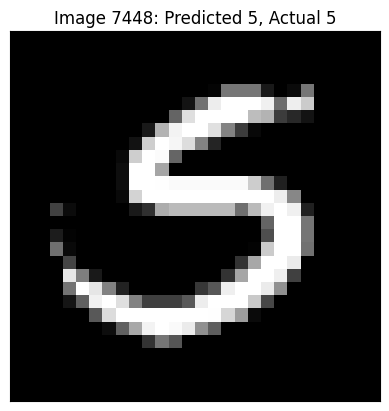


Prediction by TFNN NN


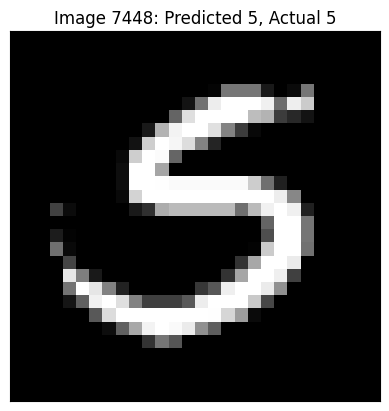


Custom NN: Loss: 0.0456, Accuracy: 92.74%
Custom NN: Loss: 0.0832, Accuracy: 97.32%



In [10]:
import random

# Demo function to predict and visualize results
def demo_predict(index, tf=False):
    X_train, Y_train, X_test, Y_test = load_mnist(unwrap=tf)

    nnetwork =  NeuralNetwork.load(NN_FILE_PATH + "nn_3.npz") if not tf else TensorflowNeuralNetwork.load(NN_FILE_PATH + "tf_nn.keras")

    if not nnetwork:
      print("Cannot load weights and biases.")
      return

    if tf:
        x_test = X_test[index:index+1, :]
        y_test = npb.argmax(Y_test[index:index+1, :], axis=1)
    else:
        x_test = X_test[:, index:index+1]
        y_test = np.argmax(Y_test[:, index:index+1], axis=0)

    # Forward pass through the network to predict]
    predicted = nnetwork.predict(x_test)

    # If on GPU marshal data to cpu
    x_display = np.asnumpy(x_test) if is_cupy else x_test
    y_display = np.asnumpy(y_test[0]) if is_cupy else y_test[0]

    # Display the image and prediction results
    show_prediction(x_display, index, predicted[0], y_display)

    # Return (loss, accuracy) for output
    return nnetwork.evaluate(X_test, Y_test)

n = random.randint(0, 10000)

print("Prediction by Default NN")
loss1, acc1 = demo_predict(n, False)
print("")

print("Prediction by TFNN NN")
loss2, acc2 = demo_predict(n, True)
print("")

print(f"Custom NN: Loss: {round(loss1, 4)}, Accuracy: {round(acc1*100, 2)}%")
print(f"Custom NN: Loss: {round(loss2, 4)}, Accuracy: {round(acc2*100, 2)}%")
print("")

Neural Network Performance graphs

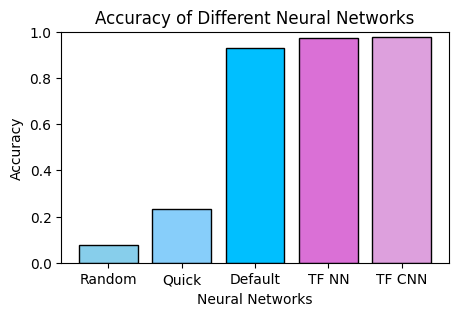

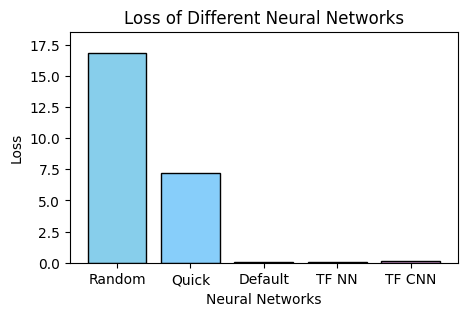

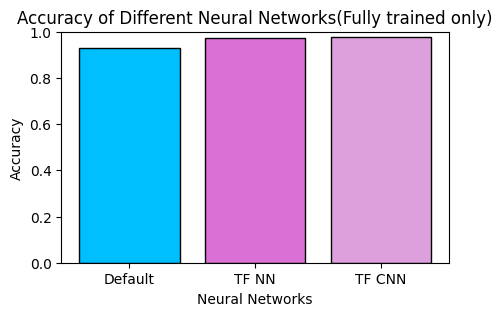

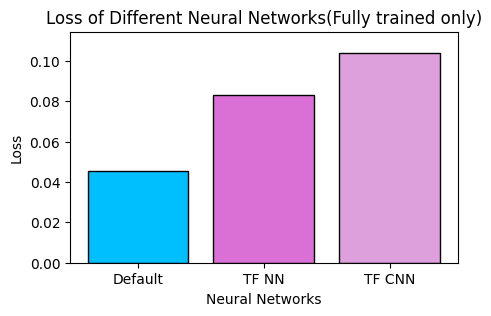

In [14]:
import math as math
# Load the trained networks
NETWORKS = {
    "Random": NeuralNetwork.load(NN_FILE_PATH + "nn_1.npz"),
    "Quick": NeuralNetwork.load(NN_FILE_PATH + "nn_2.npz"),
    "Default": NeuralNetwork.load(NN_FILE_PATH + "nn_3.npz"),
    "TF NN": TensorflowNeuralNetwork.load(NN_FILE_PATH + "tf_nn.keras"),
    "TF CNN": TensorflowNeuralNetwork.load(NN_FILE_PATH + "tf_cnn.keras")
}

# Evaluate each network and collect accuracy and loss values
accuracies = []
losses = []

for name, nn in NETWORKS.items():
    # Load MNIST data (use unwrap depending on whether it's TensorFlow)
    _, _, X_test, Y_test = load_mnist(unwrap=name.startswith('TF'))

    # Evaluate the network
    loss, accuracy = nn.evaluate(X_test, Y_test)
    accuracies.append(accuracy)
    losses.append(loss)

figure_shape = (5, 3)

def plotit(networks, values, start, name, height, title=''):
  COLORS = ['skyblue', 'lightskyblue', 'deepskyblue', 'orchid', 'plum']

  networks = networks[start:]
  values = values[start:]

  plt.figure(figsize=figure_shape)
  plt.bar(networks, values, color=COLORS[start:], edgecolor='black')
  plt.xlabel('Neural Networks')
  plt.ylabel(name)
  plt.title(name + ' of Different Neural Networks' + title)
  plt.ylim([0, height])
  plt.show()
  print("\n\n\n")

networks = list(NETWORKS.keys())
plotit(networks, accuracies, 0, 'Accuracy', 1)
plotit(networks, losses, 0, 'Loss', round(max(losses)*1.1, 4))
plotit(networks, accuracies, 2, 'Accuracy', 1, '(Fully trained only)')
plotit(networks, losses, 2, 'Loss', round(max(losses[2:])*1.1, 4), '(Fully trained only)')

### Demo

Interactive Demo allowing you to see all the neural networks are performing

In [15]:
# Create an interactive widget for visualization
def interactive_demo():
    NETWORKS = {
          "Random": NeuralNetwork.load(NN_FILE_PATH + "nn_1.npz"),
          "Quick": NeuralNetwork.load(NN_FILE_PATH + "nn_2.npz"),
          "Default": NeuralNetwork.load(NN_FILE_PATH + "nn_3.npz")           ,
          "TF NN": TensorflowNeuralNetwork.load(NN_FILE_PATH + "tf_nn.keras"),
          "TF CNN": TensorflowNeuralNetwork.load(NN_FILE_PATH + "tf_cnn.keras")
    }

    # Create UI widgets
    model_dropdown = widgets.Dropdown(options=list(NETWORKS.keys()), value="Default", description='Model:')
    filter_dropdown = widgets.Dropdown(options=['All', 'Correct Only', 'Incorrect Only'], value='All', description='Filter:')
    index_slider = widgets.IntSlider(min=1, max=1, step=1, value=1, description='Index:')

    count_label = widgets.Label(value=f"")
    accuracy_label = widgets.Label(value=f"")
    loss_label = widgets.Label(value=f"")
    correct_label = widgets.Label(value=f"")
    incorrect_label = widgets.Label(value=f"")
    prediction_label = widgets.Label(value=f"")

    predict_button = widgets.Button(description='Predict', disabled = False, layout=widgets.Layout(color='black'))
    output = widgets.Output()

    correct_indices = []
    incorrect_indices = []
    filtered_indices = list(range(10000))


    # Helper Functions
    def is_tf():
        """Helper to determine if a Tensorflow NN is selected"""
        return model_dropdown.value[0] == 'T'

    def get_filtered_data(filter_option):
        if filter_option == 'Correct Only':
            return correct_indices
        elif filter_option == 'Incorrect Only':
            return incorrect_indices
        else:
            return filtered_indices

    def filter_data(filter_option='All'):
        with output:
          output.clear_output(wait=True)
          show_empty()

        data = get_filtered_data(filter_option)
        # Reset slider and plot
        index_slider.min = 1
        index_slider.value = 1
        index_slider.max = len(data)
        count_label.value = f"of {len(data)}"
        prediction_label.value = ""

    def predict_and_plot(index):
        data = get_filtered_data(filter_dropdown.value)

        idx = data[index]

        _, _, X_test, Y_test = load_mnist(unwrap=is_tf())
        if is_tf():
            x_test, y_test = X_test[idx:(idx+1), :], npb.argmax(Y_test[idx:(idx+1), :], axis=1)
        else:
            x_test, y_test = X_test[:, idx:(idx+1)], np.argmax(Y_test[:, idx:(idx+1)], axis=0)

        nnetwork = NETWORKS[model_dropdown.value]

        time_start = time.time()
        predicted = nnetwork.predict(x_test)
        predict_time = time.time() - time_start

        x_display = np.asnumpy(x_test) if is_cupy else x_test
        prediction_label.value = ""
        # Display the image and prediction results
        with output:
            output.clear_output(wait=True)
            show_prediction(x_display, idx+1, predicted[0], y_test[0])
            prediction_label.value = f"Prediction took {round(predict_time, 5)} seconds"

    def change_model(new, old = None):
        # Don't run if there's no change
        if old == new:
            return

        nnetwork = NETWORKS[new] # Selected network

        # On Change, reset and load/sort data again
        incorrect_indices.clear()
        correct_indices.clear()

        _, _, X_test, Y_test = load_mnist(unwrap=is_tf())
        axis = 1 if is_tf() else 0

        predicted = nnetwork.predict(X_test)
        actual = npb.argmax(Y_test, axis=axis) if is_tf() else np.argmax(Y_test, axis=axis)

        # Precompute correct and incorrect indices at startup
        for i in filtered_indices:
            if predicted[i] == actual[i]:
                correct_indices.append(i)
            else:
                incorrect_indices.append(i)

        loss, accuracy = nnetwork.evaluate(X_test, Y_test)
        accuracy_label.value = f"""Accuracy: {round(accuracy, 4)}"""
        loss_label.value = f"""Loss: {round(loss, 4)}"""
        correct_label.value = f"""Correct: {len(correct_indices)}"""
        incorrect_label.value = f"""Incorrect: {len(incorrect_indices)}"""

        # If 'All' dropdown is already selected, we just reset directly
        # Otherwise we let the UI event system handle
        if filter_dropdown.value == 'All':
            filter_data()
        else:
            filter_dropdown.value = 'All'

    # Setup UI Event handlers
    model_dropdown.observe(lambda change: change_model(change.new, change.old), names='value')
    filter_dropdown.observe(lambda change: filter_data(filter_dropdown.value), names='value')
    predict_button.on_click(lambda change: predict_and_plot(index_slider.value-1))

    # Display UI
    layout = widgets.Layout(padding='10px', margin='5px')
    display(widgets.HBox([
        widgets.VBox([model_dropdown, filter_dropdown, widgets.HBox([index_slider, count_label])], layout=layout),
        widgets.VBox([accuracy_label, correct_label], layout=layout),
        widgets.VBox([loss_label, incorrect_label], layout=layout)]))
    display(widgets.HBox([widgets.VBox([output, prediction_label]), widgets.HTML("&nbsp"), predict_button]))

    # Initialize based on default widget values
    change_model(model_dropdown.value)

# Run the interactive demo
interactive_demo()

### Conclusion

In this project, I have implemented a custom neural network to understand the mechanics of neural network comparing it to an equivalent TensorFlow Neural Network implementation. We found that the custom neural network performed similarly to TensorFlow in terms of loss and accuracy, TensorFlow's GPU acceleration offered a significant speed advantage, making it far more efficient for larger datasets or real-time applications.

Additionally, I explored a convolutional neural network (CNN) to evaluatehow well it performed the given task. While the CNN outperformed both the custom and TensorFlow neural networks in terms of accuracy, the computational cost was substantial, particularly on a CPU. Therefore training/predicting with a CNN was impractical for our project's requirements. Thus, while CNNs offer superior predictive performance, they were deemed overkill for this specific context.

This comparison highlights the trade-offs between customization, performance, and computational resources in neural network development.